# Eigen Faces

In this notebook, we will learn about Eigenface — a very interesting application of Principal Component Analysis (PCA) for human faces.
 
## <font style="color:rgb(50,120,229)">What are EigenFaces ? </font>


Eigenfaces are images that can be added to a mean (average) face to create new facial images. We can write this mathematically as,



$ F = F_{m} + \sum \limits _{i=1} ^{n} \alpha_{i}F_{i} $

where,

 - $ F $ is a new face.
 - $ F_{m} $ is the mean or the average face.
 - $ F_{i} $ is an EigenFace.
 - $ \alpha_{i} $ are scalar multipliers we can choose to create new faces. They can be positive or negative.
 
Eigenfaces are calculated by estimating the principal components of the dataset of facial images. They are used for applications like Face Recognition and Facial Landmark Detection.

## <font style="color:rgb(50,120,229)">How to calculate EigenFaces?</font>

To calculate EigenFaces, we need to go through the following steps.

 - Obtain a facial image dataset.
 - Align and resize images.
 - Create a data matrix.
 - Calculate Mean Vector **[Optional].**
 - Calculate Principal Components.
 - Reshape Eigenvectors to obtain EigenFaces.


## <font style="color:rgb(50,120,229)">Import Libraries</font>


In [1]:
# Import necessary packages.
from __future__ import print_function
import os
import sys
import cv2
import numpy as np

## <font style="color:rgb(50,120,229)">Read Images</font>

The dataset must be processed so that the centre of the eyes are same and each image has same size. In our case we are using pre-processed images from [calebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html), which do not require alignment and resizing. Here, we read all images in the specified directory using the defined function **readImages**. The directory contains images that are aligned. The center of the left and the right eyes in all images are the same. We add these images to a list ( or vector ). We also flip the images vertically and add them to the list. Because the mirror image of a valid facial image, we just doubled the size of our dataset and made it symmetric at that same time.

In [3]:
# Read images from the directory.
def readImages(path):
    print("Reading images from " + path, end = "...")
    # Create array of array of images.
    images = []
    # List all files in the directory and read points from text files one by one.
    for filePath in sorted(os.listdir(path)):
        fileExt = os.path.splitext(filePath)[1]
        if fileExt in [".jpg", ".jpeg"]:

            # Add to array of images.
            imagePath = os.path.join(path, filePath)
            im = cv2.imread(imagePath)

            if im is None :
                print("image:{} not read properly".format(imagePath))
            else :
                # Convert image to floating point.
                im = np.float32(im)/255.0
                # Add image to list.
                images.append(im)
                # Flip image.
                imFlip = cv2.flip(im, 1);
                # Append flipped image.
                images.append(imFlip)
    numImages = int(len(images) / 2)
    # Exit if no image found.
    if numImages == 0 :
        print("No images found")
        sys.exit(0)

    print(str(numImages) + " files read.")
    return images

## <font style="color:rgb(50,120,229)">Create Data Matrix</font>

Create a data matrix containing all images as a row vector. Next, we use the function **createDataMatrix** to assemble the images into a data matrix. Each row of the data matrix is one image. Let’s look into the createDataMatrix function. If all the images in the dataset are of size 100 x 100 and there are 1000 images, we will have a data matrix of size 30k x 1000. So, according to our example, `numImages = 1000, sz[0] = 100, sz[1] = 100 and sz[2] = 3`. `flatten` returns a copy of the array collapsed into one dimension.


In [5]:
# Create data matrix from a list of images.
def createDataMatrix(images):
    print("Creating data matrix", end = " ... ")

    numImages = len(images)
    sz = images[0].shape
    # Data matrix.
    data = np.zeros((numImages, sz[0] * sz[1] * sz[2]), dtype = np.float32)
    for i in range(0, numImages):
        image = images[i].flatten()
        # Each row get replaced with one flattened image.
        data[i,:] = image

    print("DONE")
    return data

## <font style="color:rgb(50,120,229)">Generate New Face</font>

The averageFace is calculated below in the main function. We add the output and the weighted eigen faces to generate different results. The weight parameter is acquired from the trackbar position. We use the logic, `weight = sliderValues[i] - MAX_SLIDER_VALUE/2` as OpenCV does not allow slider values to be negative. Finally we resize the image to double of its original size.

### <font style="color:rgb(8,133,37)">OpenCV Documentation</font>

[**`getTrackbarPos()`**](https://docs.opencv.org/4.5.2/d7/dfc/group__highgui.html#ga122632e9e91b9ec06943472c55d9cda8)

[**`resize()`**](https://docs.opencv.org/4.5.2/da/d54/group__imgproc__transform.html#ga47a974309e9102f5f08231edc7e7529d)

In [8]:
def createNewFace(*args):
    # Start with the mean image.
    output = averageFace

    # Add the eigen faces with the weights.
    for i in range(0, NUM_EIGEN_FACES):
        # Get trackbar position.
        sliderValues[i] = cv2.getTrackbarPos("Weight" + str(i), "Trackbars");
        weight = sliderValues[i] - MAX_SLIDER_VALUE/2
        # Add the weighted eigen face to the mean face.
        output = np.add(output, eigenFaces[i] * weight)

    # Display Result at 2x size.
    output = cv2.resize(output, (0,0), fx = 2, fy = 2)
    cv2.imshow("Result", output)

## <font style="color:rgb(50,120,229)">Reset Sliders</font>

This is the callback function for mouse hover on the `Average` named window. By doing so, we reset the sliders and at the same time reset the output to its preveous state.

### <font style="color:rgb(8,133,37)">OpenCV Documentation</font>

[**`setTrackbarPos()`**](https://docs.opencv.org/4.5.2/d7/dfc/group__highgui.html#ga67d73c4c9430f13481fd58410d01bd8d)

In [10]:
def resetSliderValues(*args):
    for i in range(0, NUM_EIGEN_FACES):
        cv2.setTrackbarPos("Weight" + str(i), "Trackbars", int(MAX_SLIDER_VALUE/2));
    createNewFace()

## <font style="color:rgb(50,120,229)">Main Function</font>

This is the main function. As mentioned earlier, the workflow starts with creation of data matrix, then Principal Component Analysis, followed by reshaping of eigen vectors to obtain eigen faces. OpenCV has built-in function for PCA calculation, `PCACompute`.

### <font style="color:rgb(8,133,37)">Function Syntax </font>

```python
mean, eigenvectors  =  cv.PCACompute( data, mean[, maxComponents] )
```
**Parameters**:
 - `data` : The data matrix containing every data point as either a row or a column vector. If our data consists of 1000 images, and each image is a 30k long row vector, the data matrix will of size 30k x 1000.
 - `mean` : The average of the data. If every data point in the data matrix is a 30k long row vector, the mean will also be a vector of the same size. This parameter is optional and is calculated internally if it is not supplied.
 - `maxComponents` : The maximum number of principal components is usually the smaller of the two values 1) Dimensionality of the original data ( in our case it is 30k ) 2) The number of data points ( e.g. 1000 in the above example ). However, we can explicity fix the maximum number of components we want to calculate by setting this argument. For example, we may be interested in only the first 50 principal components. Calculating fewer principal components is cheaper than calculating the theoretical max.


Reading images from C:\Users\gowri\OneDrive\Desktop\projects\eigenface\images...237 files read.
Creating data matrix ... DONE
DONEulating PCA ...


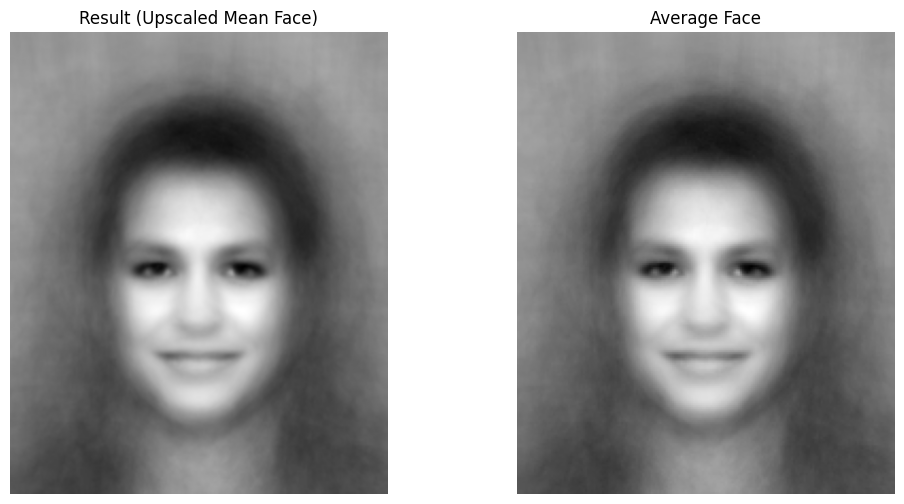

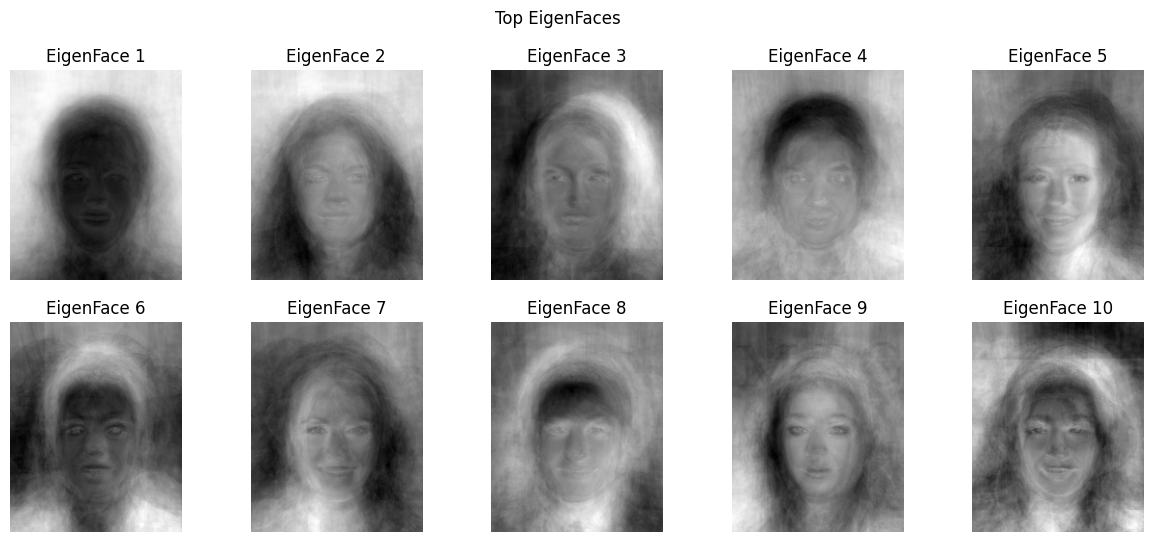

In [12]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

def readImages(directory):
    images = []
    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append(img)
    print(f"Reading images from {directory}...{len(images)} files read.")
    return images

def createDataMatrix(images):
    print("Creating data matrix ...", end=" ")
    numImages = len(images)
    sz = images[0].shape
    data = np.zeros((numImages, sz[0] * sz[1]), dtype=np.float32)
    for i, img in enumerate(images):
        data[i, :] = img.flatten()
    print("DONE")
    return data

# Your main logic
if __name__ == '__main__':

    # Number of EigenFaces.
    NUM_EIGEN_FACES = 10

    # Directory containing images.
    dirName = r"C:\Users\gowri\OneDrive\Desktop\projects\eigenface\images"

    # Read images.
    images = readImages(dirName)

    # Size of images.
    sz = images[0].shape

    # Create data matrix for PCA.
    data = createDataMatrix(images)

    # Compute the eigenvectors from the stack of images created.
    print("Calculating PCA ", end="...")
    mean, eigenVectors = cv2.PCACompute(data, mean=None, maxComponents=NUM_EIGEN_FACES)
    print("DONE")

    averageFace = mean.reshape(sz)

    # Create a container to hold eigen faces.
    eigenFaces = []
    for eigenVector in eigenVectors:
        eigenFace = eigenVector.reshape(sz)
        eigenFaces.append(eigenFace)

    # Upscale average face
    output = cv2.resize(averageFace, (0, 0), fx=2, fy=2)

    # Plot using matplotlib
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].set_title("Result (Upscaled Mean Face)")
    axes[0].imshow(output, cmap='gray')
    axes[0].axis('off')

    axes[1].set_title("Average Face")
    axes[1].imshow(averageFace, cmap='gray')
    axes[1].axis('off')

    plt.show()

    # Optionally, show eigenfaces
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()
    for i in range(NUM_EIGEN_FACES):
        axes[i].imshow(eigenFaces[i], cmap='gray')
        axes[i].set_title(f'EigenFace {i+1}')
        axes[i].axis('off')
    plt.suptitle("Top EigenFaces")
    plt.show()


## <font style="color:rgb(50,120,229)">Image Loading Function</font>

This section reads all images from a specified directory and stores them in a list for further processing. It is a foundational step in any computer vision or machine learning pipeline involving image data. Images are read in grayscale mode to reduce complexity and focus on intensity patterns, which is particularly useful for face recognition tasks.

### <font style="color:rgb(8,133,37)">Function Syntax</font>

```python
img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
```

**Parameters**:
 - `filepath` : The complete path to the image file, including the filename and extension. For example, `C:\Users\gowri\OneDrive\Desktop\projects\eigenface\images\000001.jpg`.
 - `cv2.IMREAD_GRAYSCALE` : A flag that tells OpenCV to read the image as a grayscale image. This reduces the image to a single channel, making subsequent processing simpler and more efficient.

**Process Description**:
 - The code iterates over all files in the given directory.
 - It selects files ending with `.jpg`, ensuring only image files are processed.
 - For each image file, it constructs the full path and loads the image in grayscale.
 - Only successfully loaded images are added to the `images` list.
 - The corresponding filenames are also stored for future reference (such as mapping images to labels).
 - After loading all images, it prints the total number of images read, providing a quick check on the dataset size.

This step ensures a clean and consistent dataset, ready for further analysis such as Principal Component Analysis (PCA) or training a recognition model.

In [14]:
import os
import cv2
import numpy as np

dirName = r'C:\Users\gowri\OneDrive\Desktop\projects\eigenface\images'  # update this as needed

images = []
filenames = []

for filename in sorted(os.listdir(dirName)):
    if filename.endswith('.jpg'):
        filepath = os.path.join(dirName, filename)
        img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append(img)
            filenames.append(filename)
print(f"Read {len(images)} images.")

Read 237 images.


## <font style="color:rgb(50,120,229)">Face Recognition Model Training</font>

This section is the core of the face recognition process. It uses the features extracted via Principal Component Analysis (PCA) to train a machine learning classifier capable of distinguishing between different faces. The workflow transitions from raw pixel data to a compact, information-rich representation (the "eigenface" space), and then uses these features to train a classifier for recognition.

### <font style="color:rgb(8,133,37)">Projecting Images to PCA Space</font>

After PCA is computed on the image data (`mean` and `eigenVectors`), each image is projected into the same reduced-dimensionality space. This process transforms each image from a high-dimensional vector (one dimension per pixel) to a much smaller vector (one dimension per principal component/eigenface), greatly improving computational efficiency and reducing noise.

```python
projected_data = cv2.PCAProject(data, mean, eigenVectors)
```

**Parameters**:
 - `data` : The original data matrix, where each row is a flattened image.
 - `mean` : The mean vector computed from all images, used to center the data before projection.
 - `eigenVectors` : The principal components (eigenfaces) computed via PCA, representing the directions of maximum variance in the data.

**Process Description**:
 - Each image is centered by subtracting the mean.
 - The centered data is then projected onto the eigenfaces, resulting in a compact representation for each image.
 - The output, `projected_data`, is a matrix of shape `[number_of_images, number_of_eigenfaces]`. Each row contains the coefficients (weights) for the eigenfaces, representing how much each principal component contributes to the image.

---

### <font style="color:rgb(8,133,37)">Splitting Data for Training and Testing</font>

To evaluate the effectiveness of the recognition model, the projected data is split into training and testing sets. This ensures that the model is trained on one subset and evaluated on unseen data, providing a realistic measure of its performance.

```python
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    projected_data, labels, test_size=0.2, random_state=42
)
```

**Parameters**:
 - `projected_data` : The PCA-projected features for all images.
 - `labels` : The ground truth identity labels for each image.
 - `test_size` : Fraction of data reserved for testing (here, 20%).
 - `random_state` : Seed for reproducibility of the train/test split.

**Process Description**:
 - The function randomly partitions the data and corresponding labels into training and testing sets.
 - `X_train`, `y_train` contain the features and labels used to train the model.
 - `X_test`, `y_test` are reserved for evaluating the model's accuracy on unseen images.

---

### <font style="color:rgb(8,133,37)">Training the Classifier</font>

Once the data is prepared, a Support Vector Machine (SVM) classifier is trained using the PCA features. SVM is a powerful algorithm for high-dimensional data and is widely used for face recognition tasks.

```python
from sklearn.svm import SVC

clf = SVC(kernel='linear')
clf.fit(X_train, y_train)
```

**Parameters**:
 - `kernel='linear'` : Specifies a linear decision boundary, suitable for linearly separable PCA features.
 - `X_train` : The training features (PCA coefficients).
 - `y_train` : The labels corresponding to each training image.

**Process Description**:
 - The SVM learns to separate different identities in the reduced PCA feature space.
 - It finds the optimal hyperplane that best distinguishes between classes (faces) using the provided features.
 - Once trained, the classifier can predict the identity of new images based on their PCA-projected features.

---

**Overall Workflow Summary**:
1. Reduce the dimensionality of image data by projecting onto the most informative directions (eigenfaces) with PCA.
2. Split the compact features into training and testing sets, ensuring the evaluation is valid and unbiased.
3. Train a machine learning classifier (SVM) to distinguish between different faces using these features.
4. The resulting model can accurately and efficiently recognize new faces, provided the training data is representative.

This section encapsulates the most critical step in the face recognition pipeline, transforming raw image data into actionable predictions through mathematical feature extraction and machine learning.

In [49]:
# After calculating mean, eigenVectors with PCA
# Project all data onto PCA space
projected_data = cv2.PCAProject(data, mean, eigenVectors)  # shape: [n_images, NUM_EIGEN_FACES]

# Use projected_data for train/test, not raw data
X_train, X_test, y_train, y_test = train_test_split(projected_data, labels, test_size=0.2, random_state=42)

clf = SVC(kernel='linear')
clf.fit(X_train, y_train)

SVC(kernel='linear')

## <font style="color:rgb(50,120,229)">Identity Prediction Function</font>

This function predicts the identity of a face in a new image using the trained model and PCA features.

- **Reads the image** from the given path in grayscale.
- **Flattens the image** into a 1D array, matching the format used for training.
- **Projects the image** onto the PCA space (eigenfaces), reducing dimensionality.
- **Uses the trained classifier** to predict the label (identity) corresponding to the input image.
- **Prints and returns** the predicted label.

This is the final step in the recognition pipeline, converting a raw input image into a predicted identity.

**Example usage:**
```python
predicted = predict_identity("path/to/image.jpg")
```

In [51]:
def predict_identity(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img_flat = img.flatten().astype(np.float32).reshape(1, -1)
    img_pca = cv2.PCAProject(img_flat, mean, eigenVectors)
    label_pred = clf.predict(img_pca)
    print(f"Predicted label (filename number): {label_pred[0]}")
    return label_pred[0]

In [53]:
test_img_path = r"C:\Users\gowri\OneDrive\Desktop\projects\eigenface\images\000123.jpg"
predicted = predict_identity(test_img_path)

Predicted label (filename number): 123
